# Querying the Gaia DR3 database
16 March 2023


***
## The Hertzsprung-Russell Diagram in the Gaia era
For additional information about the ESA Gaia mission, have a look at: https://sci.esa.int/web/gaia and for information specific the the current data released (eDR3) see https://www.cosmos.esa.int/web/gaia/

Loading a few useful packages. Install them on your local computer if needed, e.g. via `pip install astroquery`

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import pandas as pd
import numpy as np
import math as m
from matplotlib import pyplot as plt

### Querying the Gaia DR3 database

This shows you all the tables with Gaia data available on the database (don't worry about reading through!)

In [2]:
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour


Here below we query the Gaia database using *ADQL*, the Astronomy Data Query Language. Do not worry about the details of the format, but focus on the criteria used to make the selection:

- the apparent magnitude in the Gaia G band, `phot_g_mean_mag`
- the parallax itself `gaia.parallax`, expressed in mas (milli arcseconds)
- the relative uncertainty on the parallax, so we consider here only stars with precise (10%) determiations of parallax (distance)

In the example given here we are defining a sample limited by the **apparent** magnitue of the observed stars, `gaia.phot_g_mean_mag < 8`.

In [4]:
job = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS gaia \
WHERE \
gaia.phot_g_mean_mag < 8 AND \
gaia.parallax > 0 AND \
gaia.parallax_error/gaia.parallax <= 0.02;", dump_to_file=True)
print (job)

Saving results to: 1678916825820O-result.vot.gz
Jobid: 1678916825820O
Phase: COMPLETED
Owner: None
Output file: 1678916825820O-result.vot.gz
Results: None


Load the results into a table, and inspect the content. 

In [5]:
res = job.get_results()
res

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,

There is of course an enourmous amount of information! For now, just focus on these quantities, and on their combination:

- `'parallax'` in mas (milli arcseconds)
- `'phot_bp_mean_mag'` apparent magnitude in the Gaia Bp band (blue)
- `'phot_rp_mean_mag'` apparent magnitude in the Gaia Rp band (red)
- `'phot_g_mean_mag'` apparent magnitude in the Gaia G band (green), see https://www.cosmos.esa.int/web/gaia/iow_20180316 for more info on the Gaia photometric passbands.

as an exercise: 
1. plot a color-magnitude diagram (CMD), e.g. `Bp-Rp` vs the **absolute** magniture in the `G` band computed using the information you have on the parallax. Consider using a density plot or e.g. `hexbin` to highlight highly populated regions in the diagram.
2. can you recognise on the CMD any features you already know? Can you roughly place the Sun on this diagram?
3. explore CMDs resulting from different queries. A suggestion: how and why does the CMD change if you plot a distance-limited sample (e.g. all stars within 50pc) as opposed to a magnitude-limited sample?

**Warning** be careful about the selection criteria in the query: in the database there are \~1.5 billion sources down to magnitude G\~21!!!!

## Worked out example

Remember the relation between apparent magnitude, absolute magnitude and distance or parallax

$m=M +5\log{d}-5$

where d is the distance in pc. From the parallax ($\varpi$, in mas) we can infer a distance (pc):

$d=1000/\varpi$

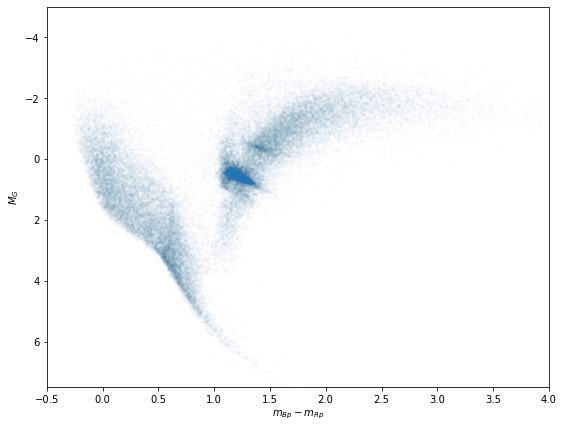

In [7]:
abs_mag=res['phot_g_mean_mag']-5*np.log10(1000./res['parallax'])+5;
col=res['phot_bp_mean_mag']-res['phot_rp_mean_mag'];
fig = plt.figure(figsize=(9, 7))
#plt.scatter(col,abs_mag,10)
plt.scatter(col,abs_mag,4, alpha=0.01)

plt.ylabel('$M_{G}$')
plt.xlabel('$m_{Bp}-m_{Rp}$')
plt.ylim([-5, 7.5])
plt.xlim([-0.5, 4])
plt.gca().invert_yaxis()


### Density plot

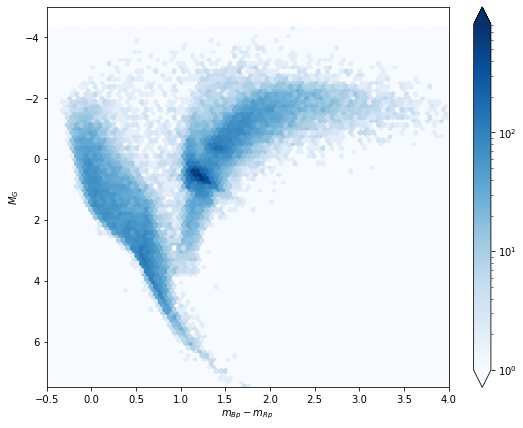

In [8]:
fig = plt.figure(figsize=(9, 7))
plt.hexbin(col, abs_mag, cmap='Blues',bins='log')
plt.ylim([-5, 7.5])
plt.xlim([-0.5, 4])
plt.ylabel('$M_{G}$')
plt.xlabel('$m_{Bp}-m_{Rp}$')
plt.gca().invert_yaxis()
cbar = plt.colorbar(extend='both')


### Changing the selction function
Now we search for stars within a given distance from the Sun (50 pc)

In [7]:
job = Gaia.launch_job_async("SELECT * \
FROM gaiaedr3.gaia_source AS gaia \
WHERE \
gaia.phot_g_mean_mag < 16 AND \
gaia.parallax > 20 AND \
gaia.parallax_error/gaia.parallax <= 0.10;", dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
res2 = job.get_results()
len(res2)


33168

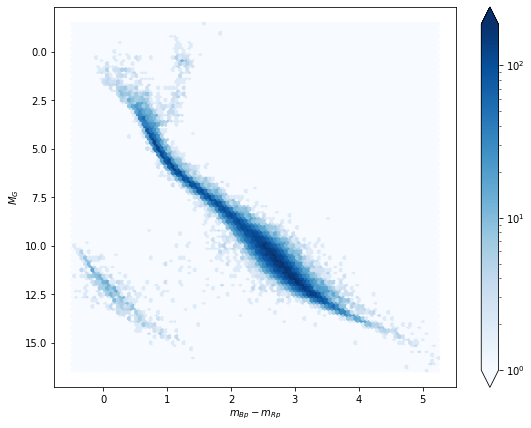

In [10]:
abs_mag2=res2['phot_g_mean_mag']-5*np.log10(1000./res2['parallax'])+5;
col2=res2['phot_bp_mean_mag']-res2['phot_rp_mean_mag'];
fig = plt.figure(figsize=(9, 7))
plt.hexbin(col2, abs_mag2, cmap='Blues',bins='log')
#plt.ylim([-5, 10.5])
#plt.xlim([-0.5, 4])
plt.ylabel('$M_{G}$')
plt.xlabel('$m_{Bp}-m_{Rp}$')
plt.gca().invert_yaxis()
cbar = plt.colorbar(extend='both')



##  Misc

convert an astropy table into pandas dataframe

In [ ]:
df=res2.to_pandas()